In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.options.mode.chained_assignment = None  # default='warn'


pd.set_option('display.max_columns', None)




In [ ]:
# Fixing the decimal point issue in the CSV file produced by java.
# Framework to process each line of the CSV (excluding the header)
def process_csv_line_by_line(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        # Read and write the header
        header = infile.readline()
        outfile.write(header)

        # Process each line
        for line in infile:
            # Replace specific commas with decimal points
            parts = line.strip().split(',')
            b_X_Y_1000 = parts[0]
            # Merge 2nd and 3rd part, with a point in between
            zaffalon_bound_lower = parts[1] + '.' + parts[2]
            # Merge 4th and 5th part, with a point in between
            zaffalon_bound_upper = parts[3] + '.' + parts[4]
            outfile.write(b_X_Y_1000 + ',' + zaffalon_bound_lower + ',' + zaffalon_bound_upper + '\n')

# Apply the framework to fix the CSV
process_csv_line_by_line('results_parallel.csv', 'results_parallel_fixed.csv')

# Load the fixed CSV into a DataFrame
zaffalon_results = pd.read_csv('results_parallel_fixed.csv')
zaffalon_results

,b_X_Y_1000,zaffalon_bound_lower,zaffalon_bound_upper
0,-4965,-0.4503,-0.3038
1,-4970,-0.3556,0.4701
2,-4990,-0.5913,-0.3255
3,-4985,-0.5807,-0.0126
4,-4975,-0.7200,-0.1801
...,...,...,...
1995,4970,0.0858,0.5280
1996,4975,-0.1414,0.4909
1997,4985,0.3481,0.7105
1998,4990,-0.0840,0.7075


In [120]:
zaffalon_results = pd.read_csv('results_parallel_fixed.csv')

data = pd.read_pickle('binaryIV_results.pkl')

zaffalon_results['b_X_Y'] = zaffalon_results['b_X_Y_1000'] / 1000
zaffalon_results.drop(columns=['b_X_Y_1000'], inplace=True)

# merge the two dataframes on the 'b_X_Y' column
data['b_X_Y'] = data['b_X_Y'].round(3)
merged = pd.merge(data, zaffalon_results, on='b_X_Y', how='left')
# looking for -4.975
data[data['b_X_Y'].round(3) == -4.975]

# Heursitically floor lower bound and ceil upper bound to the nearest 0.01
merged['zaffalon_bound_lower'] = np.floor(merged['zaffalon_bound_lower'] * 100) / 100
merged['zaffalon_bound_upper'] = np.ceil(merged['zaffalon_bound_upper'] * 100) / 100

# Heuristically subtract 0.01 from the lower bound and add 0.01 to the upper bound
inc = 0.05
merged['zaffalon_bound_lower'] = merged['zaffalon_bound_lower'] - inc
merged['zaffalon_bound_upper'] = merged['zaffalon_bound_upper'] + inc




merged['zaffalon_bounds_valid'] = (merged['zaffalon_bound_lower'] <= merged['ATE_true']) & (merged['ATE_true'] <= merged['zaffalon_bound_upper'])
merged[merged['zaffalon_bounds_valid'] == False]

merged[merged['zaffalon_bounds_valid'] == False][['ATE_true', 'zaffalon_bound_lower', 'zaffalon_bound_upper']]

# calculate the how much the ATE_true is outside the bounds
# if ATE_true < zaffalon_bound_lower, then bound_dist = ATE_true - zaffalon_bound_lower
# if ATE_true > zaffalon_bound_upper, then bound_dist = ATE_true - zaffalon_bound_upper
# merged['bound_dist'] = np.where(merged['ATE_true'] < merged['zaffalon_bound_lower'],
#                                   merged['ATE_true'] - merged['zaffalon_bound_lower'],
#                                   merged['ATE_true'] - merged['zaffalon_bound_upper'])

error_rate = merged[merged['zaffalon_bounds_valid'] == False].shape[0] / merged.shape[0]
print(f"Error rate: {error_rate:.2%}")

merged['zaffalon_bound_width'] = merged['zaffalon_bound_upper'] - merged['zaffalon_bound_lower']
merged[merged['zaffalon_bounds_valid']]['zaffalon_bound_width'].describe()


Error rate: 0.90%


count    1982.000000
mean        0.554319
std         0.192932
min         0.190000
25%         0.420000
50%         0.530000
75%         0.660000
max         1.930000
Name: zaffalon_bound_width, dtype: float64

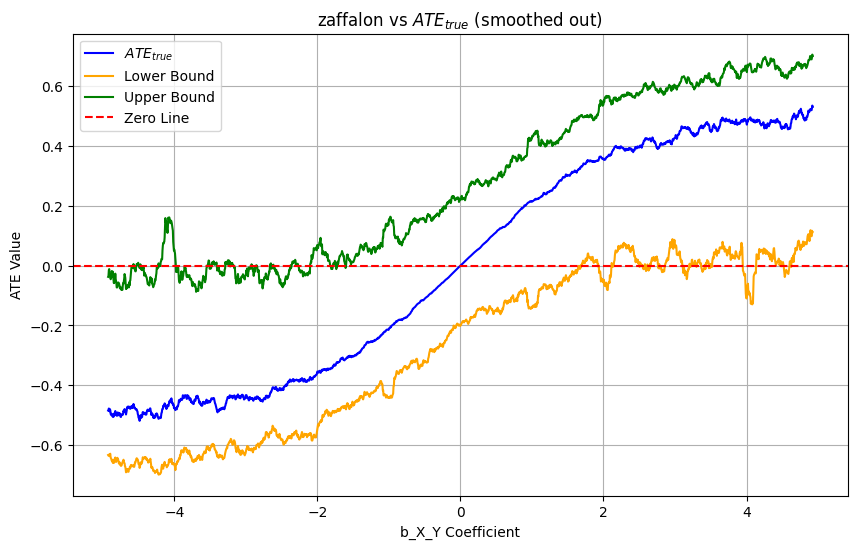

In [128]:
data = pd.read_pickle('binaryIV_results.pkl')

plot_smoothed_ate_vs_bounds(data, 'zaffalon', 30)


In [127]:
def plot_smoothed_ate_vs_bounds(dataframe, algorithm='autobound', window=1):
    """
    Plot smoothed ATE_true and algorithm confidence intervals from the given dataframe.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing columns 'ATE_true', '<algorithm>_bound_lower', '<algorithm>_bound_upper', and 'b_X_Y'.
    algorithm (str): The name of the algorithm to use for bounds (e.g., 'autobound').
    window (int): The size of the rolling window for smoothing. Default is 1.

    Returns:
    None
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()

    # Smoothen the data using a rolling average
    df['ATE_true_smooth'] = df['ATE_true'].rolling(window=window, center=True).mean()
    df[f'{algorithm}_bound_lower_smooth'] = df[f'{algorithm}_bound_lower'].rolling(window=window, center=True).mean()
    df[f'{algorithm}_bound_upper_smooth'] = df[f'{algorithm}_bound_upper'].rolling(window=window, center=True).mean()

    # Plot the smoothed data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='b_X_Y', y='ATE_true_smooth', label='$ATE_{true}$', color='blue')
    sns.lineplot(data=df, x='b_X_Y', y=f'{algorithm}_bound_lower_smooth', label='Lower Bound', color='orange')
    sns.lineplot(data=df, x='b_X_Y', y=f'{algorithm}_bound_upper_smooth', label='Upper Bound', color='green')
    plt.axhline(0, color='red', linestyle='--', label='Zero Line')
    plt.title(algorithm+' vs $ATE_{true}$ (smoothed out)')
    plt.xlabel('b_X_Y Coefficient')
    plt.ylabel('ATE Value')
    plt.legend()
    plt.grid(True)
    plt.show()